In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn

import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

import sklearn.model_selection as sk
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#압축 해제
#%cd /content/drive/MyDrive

#!unzip -qq "/content/drive/MyDrive/TrainData.zip"

In [ ]:
# Dataset path load
train_path = "/content/drive/MyDrive/Train"

In [ ]:
# Data Load
classes = ['campus', 'farm', 'train_station']  #campus:0, farm:1, train_station:2

data=[]
label=[]

## i : Integer representation for each classes (campus/farm/train_station -> 0/1/2)
for i,d in enumerate(classes):
    files = os.listdir(train_path+'/'+d)
    
    for f in files:
        img = Image.open(train_path+'/'+d+'/'+f)
        
        # Data normalization
        one_img = np.asarray(np.float32(img))
        norm_img = one_img/255.0

        img = np.asarray([norm_img])
        data.append(img)
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

total_X = torch.from_numpy(data)
total_Y = torch.from_numpy(label)

In [ ]:
#resize
Resize = transforms.Compose([
    transforms.Resize(224)
    ])

total_X = Resize(total_X)

In [ ]:
# Dataset split
X_train, X_valid, Y_train, Y_valid = sk.train_test_split(total_X, total_Y, test_size=0.2, random_state=100, stratify=total_Y)
print(X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape)


torch.Size([7200, 1, 224, 224]) torch.Size([1800, 1, 224, 224]) torch.Size([7200]) torch.Size([1800])


In [ ]:
# Data Augmentation
np.random.seed(1)
torch.manual_seed(1)

Flip = transforms.RandomHorizontalFlip(p=1)
X_Flip = Flip(X_train)

In [ ]:
# Concatenate augmented dataset
X_train = torch.cat((X_train,X_Flip))
Y_train = torch.cat((Y_train,Y_train))

print(X_train.size())
print(Y_train.size())

torch.Size([14400, 1, 224, 224])
torch.Size([14400])


In [ ]:
# DataLoader
train_dataset = TensorDataset(X_train,Y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

valid_dataset = TensorDataset(X_valid,Y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=3, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']}
model = VGG(make_layers(cfgs['D']))

In [ ]:
# Print the network you built
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def run_train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.type(torch.cuda.FloatTensor), labels.type(torch.cuda.LongTensor)
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        output = model(inputs)
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()

        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [ ]:
# Validation
def run_valid(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = inputs.type(torch.cuda.FloatTensor), labels.type(torch.cuda.LongTensor)
        inputs, labels = Variable(inputs), Variable(labels)

        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())

        
        loss = criterion(output, labels)
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

***START EPOCH***
# Epoch : 1 /25
Train Accuracy : 52.27777777777778
Validation Accuracy : 63.44444444444445
# Epoch : 2 /25
Train Accuracy : 71.15972222222223
Validation Accuracy : 76.22222222222223
# Epoch : 3 /25
Train Accuracy : 76.6736111111111
Validation Accuracy : 78.72222222222223
# Epoch : 4 /25
Train Accuracy : 80.27083333333334
Validation Accuracy : 76.77777777777777
# Epoch : 5 /25
Train Accuracy : 83.08333333333333
Validation Accuracy : 79.0


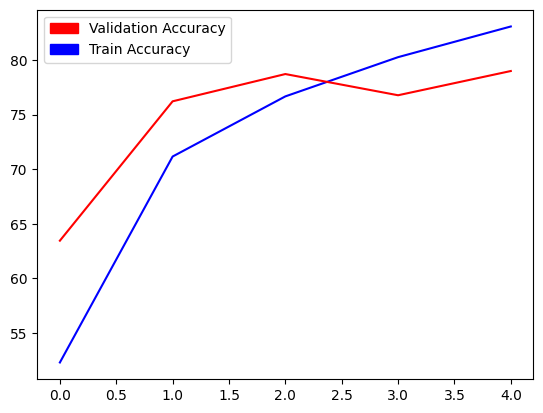

# Epoch : 6 /25
Train Accuracy : 85.61111111111111
Validation Accuracy : 84.72222222222221
# Epoch : 7 /25
Train Accuracy : 87.6111111111111
Validation Accuracy : 82.44444444444444
# Epoch : 8 /25
Train Accuracy : 89.86111111111111
Validation Accuracy : 85.33333333333334
# Epoch : 9 /25
Train Accuracy : 91.5625
Validation Accuracy : 83.27777777777777
# Epoch : 10 /25
Train Accuracy : 93.49305555555556
Validation Accuracy : 84.16666666666667


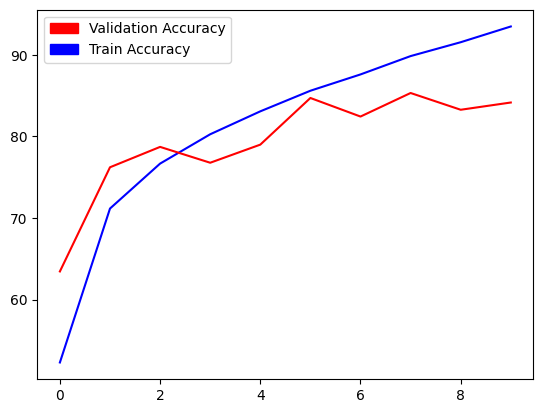

# Epoch : 11 /25
Train Accuracy : 95.69444444444444
Validation Accuracy : 85.27777777777777
# Epoch : 12 /25
Train Accuracy : 96.63194444444444
Validation Accuracy : 81.55555555555556
# Epoch : 13 /25
Train Accuracy : 96.84722222222221
Validation Accuracy : 85.11111111111111
# Epoch : 14 /25
Train Accuracy : 97.5
Validation Accuracy : 84.61111111111111
# Epoch : 15 /25
Train Accuracy : 97.41666666666666
Validation Accuracy : 84.88888888888889


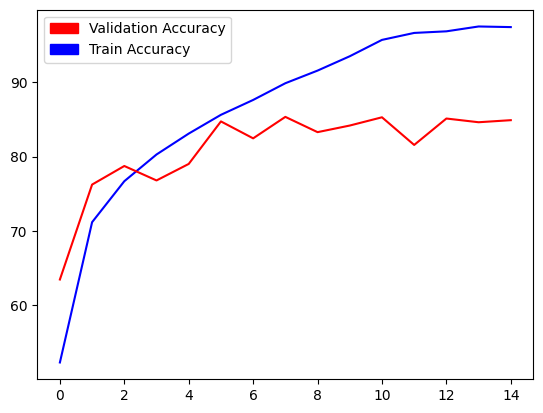

# Epoch : 16 /25
Train Accuracy : 97.68055555555556
Validation Accuracy : 84.05555555555554
# Epoch : 17 /25
Train Accuracy : 98.22916666666667
Validation Accuracy : 83.38888888888889
# Epoch : 18 /25
Train Accuracy : 98.19444444444444
Validation Accuracy : 84.88888888888889
# Epoch : 19 /25
Train Accuracy : 98.34722222222221
Validation Accuracy : 82.0
# Epoch : 20 /25
Train Accuracy : 98.48611111111111
Validation Accuracy : 84.05555555555554


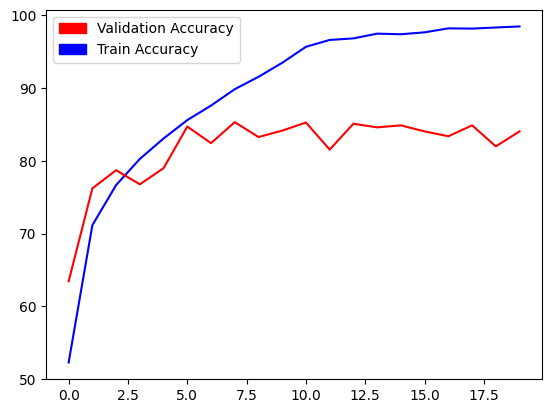

# Epoch : 21 /25
Train Accuracy : 98.63888888888889
Validation Accuracy : 84.27777777777777
# Epoch : 22 /25
Train Accuracy : 98.40277777777777
Validation Accuracy : 83.38888888888889
# Epoch : 23 /25
Train Accuracy : 98.625
Validation Accuracy : 81.83333333333334
# Epoch : 24 /25
Train Accuracy : 98.38888888888889
Validation Accuracy : 85.11111111111111
# Epoch : 25 /25
Train Accuracy : 98.58333333333333
Validation Accuracy : 83.5


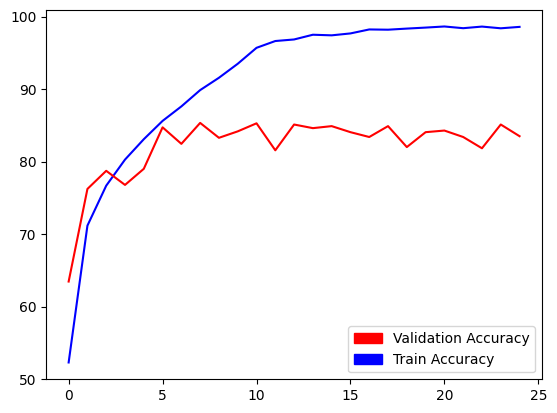

In [ ]:
# Learning 
acc_t = []
acc_v = []
epoch=25
print('***START EPOCH***')

for E in range(epoch):
    print('# Epoch : {} /25'.format(E+1))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)

    if (E+1)%5 == 0:
      plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
      blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
      red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
      plt.legend(handles=[red_patch, blue_patch])
      plt.show()

In [ ]:
# Save the weight matrices and bias vectors that will be loaded for testing later
torch.save(model,'/content/drive/MyDrive/Model_TeamD')